# Time Series Analysis

## Author: Yuanying Li

In [0]:
#Builds 'n Installs
#!pip install scipy==1.2
!pip install -q --upgrade scipy;
!pip install -q --upgrade quandl;
!pip install -q --upgrade pandas-datareader;
!pip install -q --upgrade statsmodels;

     |████████████████████████████████| 8.7MB 2.6MB/s 


In [0]:
from statsmodels.tsa.stattools import adfuller
import requests
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import io
import scipy
import quandl
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data, wb
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure
from matplotlib.pyplot import style
import matplotlib.ticker as mtick
import datetime
from datetime import date
from dateutil.parser import parse
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (16,12)
plt.style.use('seaborn-white')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


#Part 1

In [0]:
# Load Dataset
data_path="https://docs.google.com/spreadsheets/d/e/2PACX-1vR0m4BF9ASD1l5_ST-Mer3Cdj9vxbJFDNROEY51SAdvgfHUSulFTYQUA0s6K0Fr14m2KlGLd2jeYEAB/pub?output=csv"
df = pd.read_csv(data_path)
#display(df)

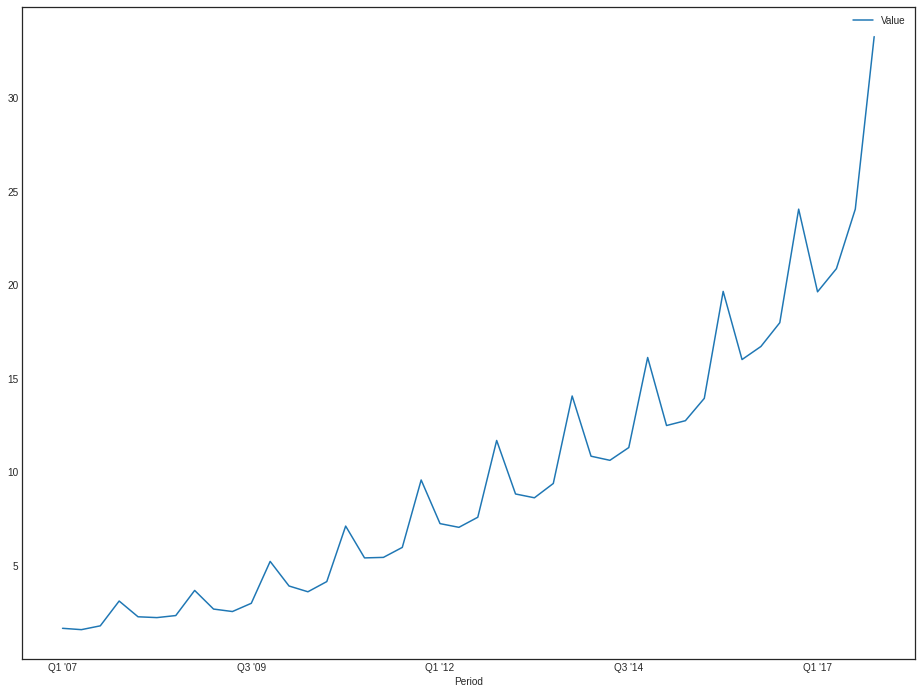

In [0]:
# Draw the raw data
ts = df.set_index('Period')
ax = ts.plot(figsize=(16,12))

## Observation:

*    The trend of data shows exponential increasing. With the increasing of 
values, each data points contributes to model differently. So we want to transform original data into reasonable scale. For example, we try to logarithm dataset to analyze, in case affect the model badly.

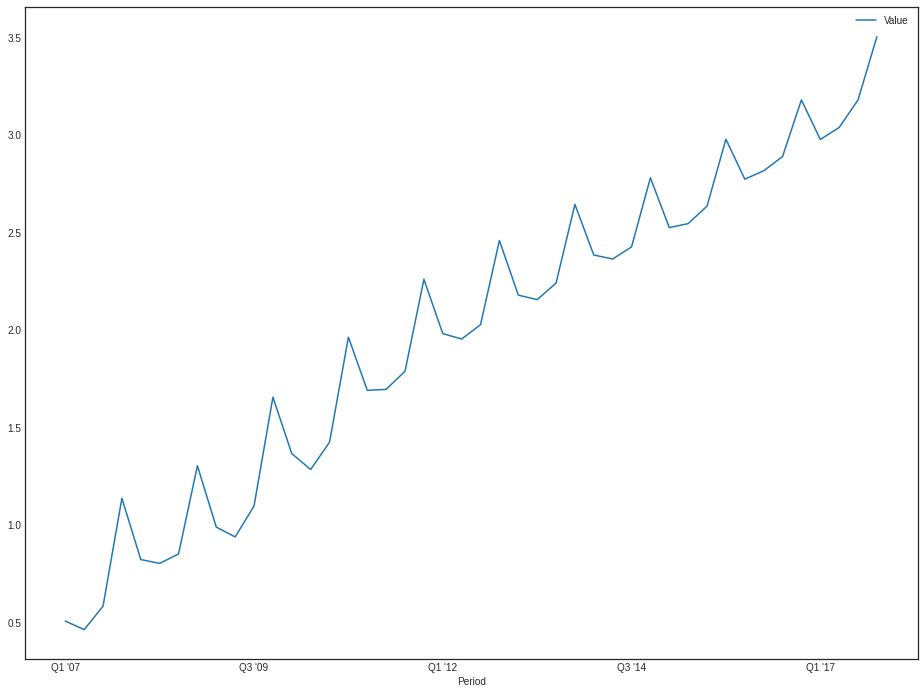

In [0]:
#Draw Logarithm dataset to analyze raw data
ts_log = np.log(ts)
ax_log = ts_log.plot(figsize=(16,12))

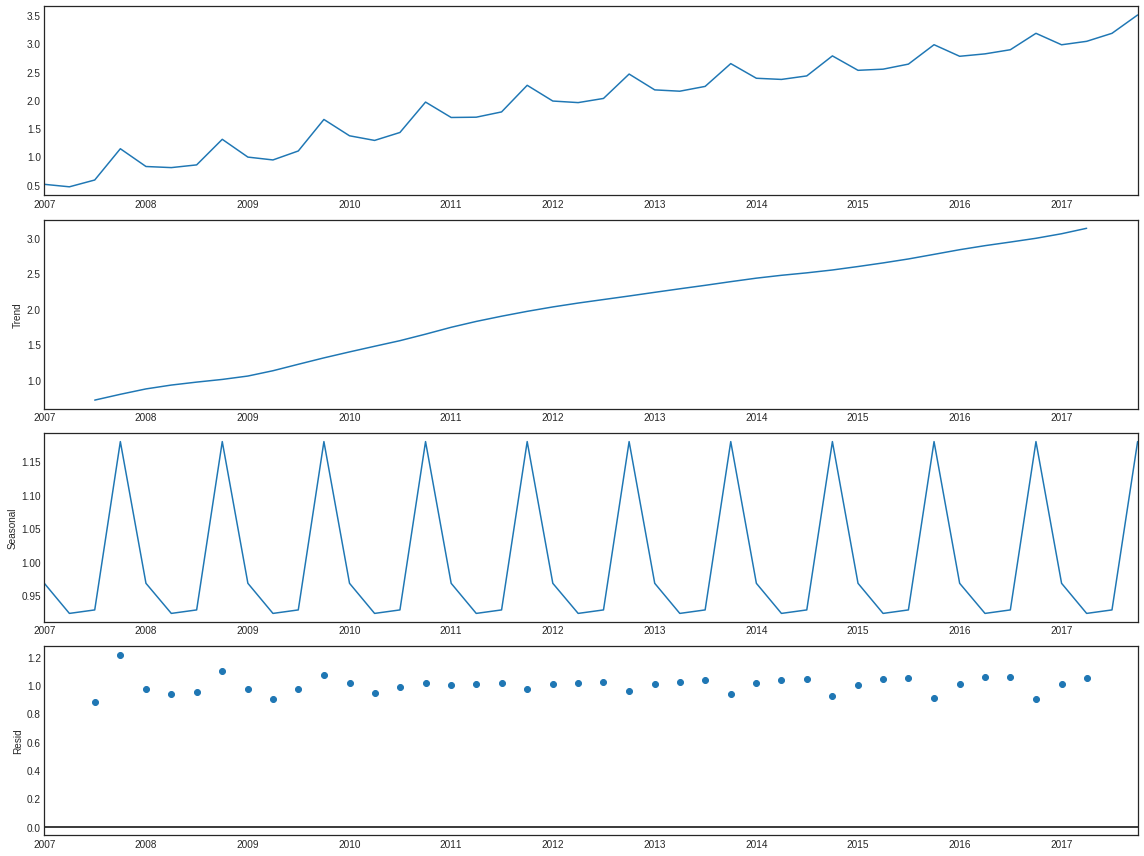

In [0]:
#Decomposing dataset 
index = pd.to_datetime([i.split()[1].replace('\'', '20')+ i.split()[0] for i in ts_log.index])
ts_log.index = index
#print(decomose_data, ts_log.values)
res = sm.tsa.seasonal_decompose(ts_log, model="multiplicative")
resplot = res.plot()

## Observation:

*    Picture 1 and 2: It is transformed data and trend data. The trendency is more likely Linear Regression. t
*    Picture 3: The picture shows data pattern along with time. The pattern is periodic.



In [0]:
#Using ARIMA Time Series Model 
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(seasonal_pdq)

#Borrowed From: https://colab.research.google.com/drive/13AWBx-vLekr6bv7_ntsbjQckprtjIdqI

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [0]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
model_output = pd.DataFrame(columns = ['parameters', 'results.aic'])

a = "bob"
b = "bob"
c = 1.0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #Only for diagnostic measures
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,
                                                  #param_seasonal, results.aic))
            a = param
            b = param_seasonal
            c = results.aic
            model_output = model_output.append({'parameters': 'ARIMA{}x{}12'.format(a, b),
                                                'results.aic': c}, ignore_index = True)
        except:
            continue

In [0]:
model_output.sort_values(by = 'results.aic').head(5)

,parameters,results.aic
28,"ARIMA(0, 1, 1)x(1, 0, 0, 12)12",-103.95
44,"ARIMA(1, 0, 1)x(1, 0, 0, 12)12",-102.07
20,"ARIMA(0, 1, 0)x(1, 0, 0, 12)12",-100.66
36,"ARIMA(1, 0, 0)x(1, 0, 0, 12)12",-99.37
52,"ARIMA(1, 1, 0)x(1, 0, 0, 12)12",-99.24


## Observation:
## 1. The predicted data has the same trend of exponential growth from the graph
## 2. After using all combinations for this algorithm, we use the smallest aic. It is the best version of this model.

In [0]:
#Fitting the model with the lowest AIC

mod = sm.tsa.statespace.SARIMAX(ts_log,
                                order=(0, 1, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4304      0.167      2.570      0.010       0.102       0.759
ar.S.L12       0.8619      0.025     35.138      0.000       0.814       0.910
sigma2         0.0017      0.001      2.357      0.018       0.000       0.003


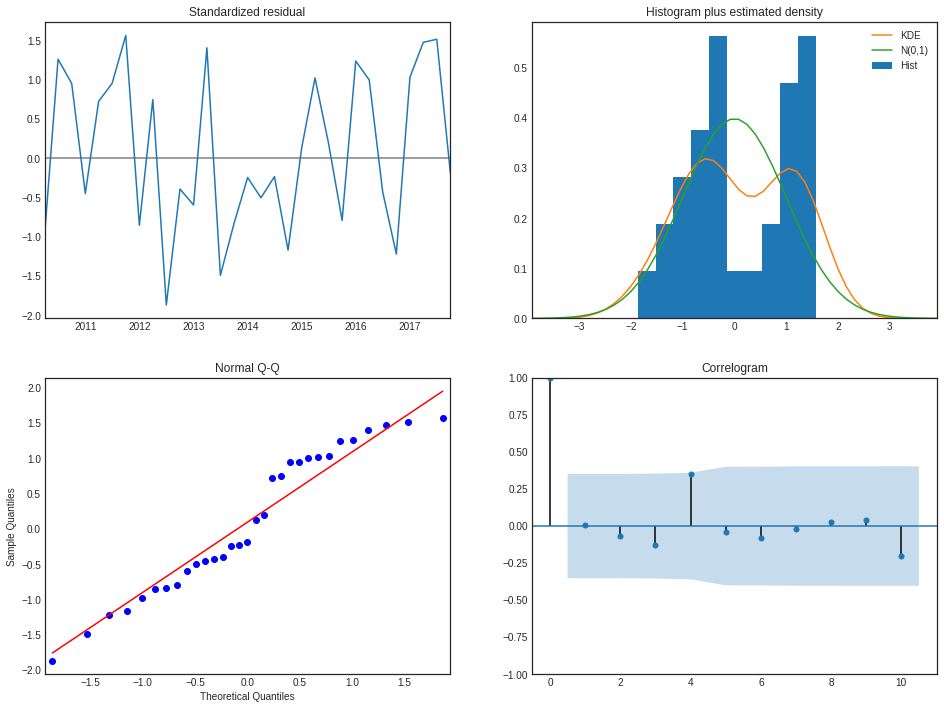

In [0]:
results.plot_diagnostics()
plt.show()

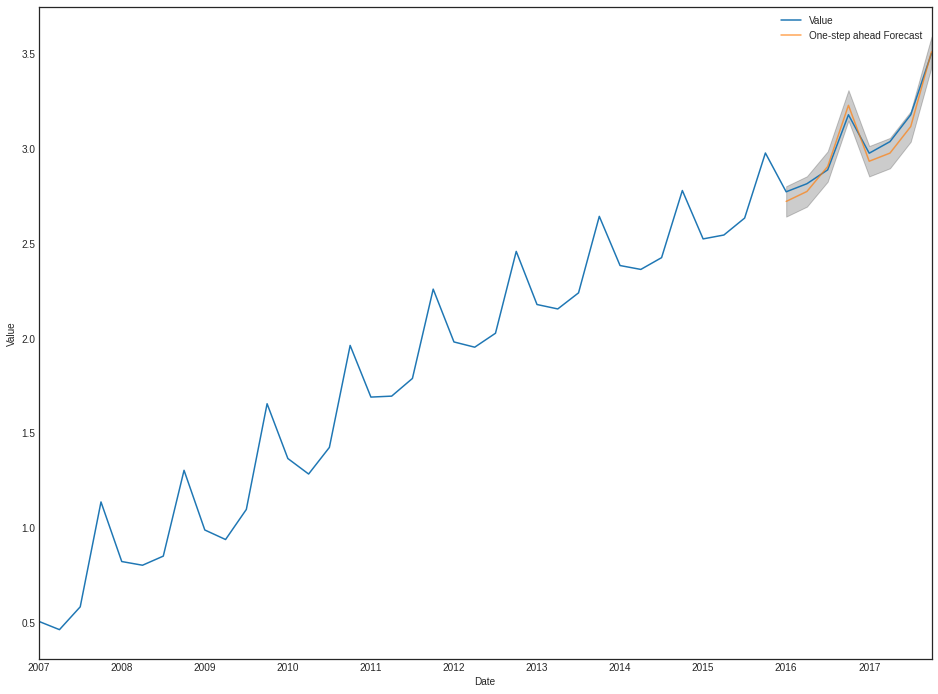

In [0]:
#Validation - not dynamic 
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
ax = ts_log['2007':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
pred_ci = pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()



## Observation:
## To understand how the model performs, we take a look at the actuals,predictions using Validation. It shows the predictions are highly same as actuals.

DatetimeIndex(['2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='QS-OCT')


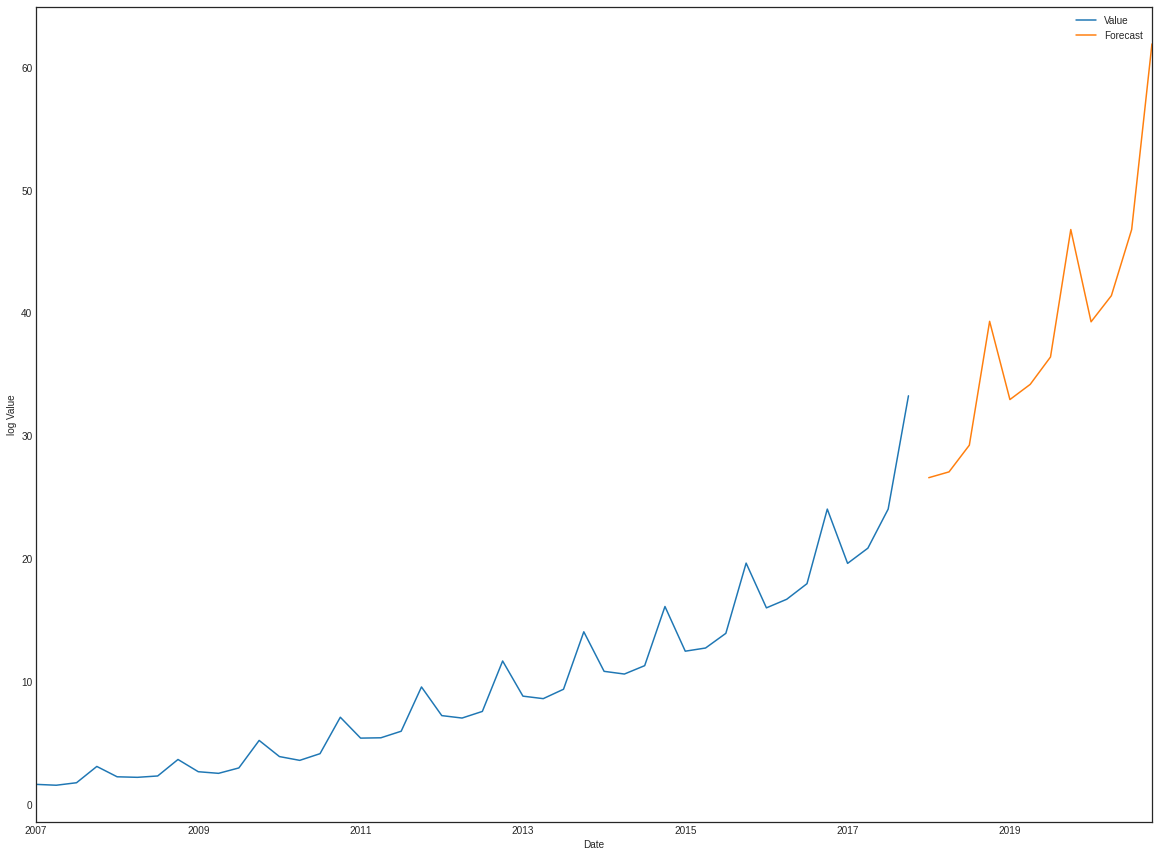

In [0]:
#Prepare for a forecast

# Get forecast 8 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
#pred_ci = pred_uc.conf_int()

ax = np.exp(ts_log).plot(label='observed', figsize=(20, 15))
np.exp(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('log Value')

plt.legend()

In [0]:
#Predicted next 8 values
print(np.exp(pred_uc.predicted_mean))

## Part 2 

In [0]:
#Load data set
#https://docs.google.com/spreadsheets/d/e/2PACX-1vQBuI4Jjy-yC0BU-_4_KWlW_hxR86-WZXM6jF_eu4QOZkMa5bKXdl-W4dOVMPl1e81jtdwjcibPqax_/pub?gid=839757165&single=true&output=csv

data_path2 = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQBuI4Jjy-yC0BU-_4_KWlW_hxR86-WZXM6jF_eu4QOZkMa5bKXdl-W4dOVMPl1e81jtdwjcibPqax_/pub?gid=839757165&single=true&output=csv"
tim = pd.read_csv(data_path2) 

In [0]:
tim.head().T

In [0]:
tim.info()

In [0]:
tim['Period'] = pd.to_datetime(tim['Period'])
tim_ds = tim.set_index(['Period'])

In [0]:
print(tim_ds.index)

In [0]:
tim_ds.head()

In [0]:
tim_ds.tail()

In [0]:
plt.xlabel('Period')
plt.ylabel("Electro")
plt.plot(tim_ds)

In [0]:
tim_dslog = np.log(tim_ds)
tim_dslog.index = tim_ds.index
plt.xlabel('Period')
plt.ylabel("Electro")
plt.plot(tim_dslog)

## Observation: 

*   We can see that from the year 1970 to 2000, there are no fluctuations in the Electro values. We can say that they are consistent for a period of approx. 30 years. After the year 2000, the value is started increasing. In the year 2010, there is a sharp increase and around mid-year, we can notice a sudden drop. The values are fluctuating and are not stationary.

In [0]:
tim_ds.plot(label='observed', figsize=(20, 15))

In [0]:
#Decomposition of original dataset 
decompose = sm.tsa.seasonal_decompose(tim_ds['Electro'].values,freq = 30)
resplot = decompose.plot()

In [0]:
#Finding rolling mean and rolling std deviation 
rolmean = tim_ds.rolling(window = 12).mean()

rolstd = tim_ds.rolling(window = 12).std()

print(rolmean, rolstd)

In [0]:
#Plot the graph 
orig = plt.plot(tim_ds, color = 'blue', label = 'Original data')
mean = plt.plot(rolmean, color = 'red', label = "Rolloing Mean")
std = plt.plot(rolstd, color= 'm', label = "Rolling Std")
plt.legend(loc = 'best')
plt.title('Rolling mean and Rolling std')
plt.show(block = False)


In [0]:
#Data is not stationary

print("Dickey-fuller Test:")
dftest = adfuller(tim_ds['Electro'],autolag= 'AIC') 

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value', 'Lags used','Number of observations used'])

for key, value in dftest[4].items(): 
  dfoutput['Critical Value (%s)' %key]  = value

print(dfoutput)

#Borrowed From: https://www.youtube.com/watch?v=e8Yw4alG16Q&t=1297s

In [0]:
#Rolling mean and Rolling std

rolmean_log = tim_dslog.rolling(window = 12).mean()

rolstd_log = tim_dslog.rolling(window = 12).std()

plt.plot(tim_dslog)
plt.plot(rolmean_log,color = 'red')


## Observation:
## The rolling mean and rolling standard deviation increase with time. Therefore, we can conclude that the time series is not stationary.

In [0]:
mean_log = plt.plot(rolmean_log, color = 'red', label = "Rolloing Mean")
std_log = plt.plot(rolstd_log, label = "Rolling Std with logarithm")
plt.legend(loc = 'best')
plt.title('Rolling mean and Rolling std in logarithm')
plt.show(block = False)

In [0]:
#Decomposition of dataset after log 
decompose_log = sm.tsa.seasonal_decompose(tim_dslog['Electro'].values,freq = 30)
resplot_log = decompose_log.plot()

In [0]:
#Using ARIMA Time Series Analysis 
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [0]:
a = "bob"
b = "bob"
c = 1.0
model_output = pd.DataFrame(columns = ['parameters', 'results.aic'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
          mod = sm.tsa.statespace.SARIMAX(tim_dslog,
                           order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
          results = mod.fit()
          a = param
          b = param_seasonal
          c = results.aic
          model_output = model_output.append({'parameters': 'ARIMA{}x{}12'.format(a, b),
                                                'results.aic': c}, ignore_index = True)

          #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [0]:
model_output.sort_values(by = 'results.aic').head(5)

In [0]:
#Selecting lowest AIC
mod = sm.tsa.statespace.SARIMAX(tim_dslog,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

In [0]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Observation:
## It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

In [0]:
#Preparing for Forecast 
pred = results.get_prediction(start=pd.to_datetime('2011-11-26'), dynamic=False)
ax = tim_ds['2007':].plot(label='observed')
np.exp(pred.predicted_mean).plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
pred_ci = pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

Since we use log to do the function, the number of index are automatically converted to only 8. So in order to fit the graph, we divide the original index and put each piece as a year to represent the real index. (For example: from about 0 to 1971).


In [0]:
forecast_index = []
time_piece = (tim_ds.index[-1] - tim_ds.index[0]) / len(tim_ds.index)
for i in range(1, 9):
  forecast_index.append(tim_ds.index[-1] + i * time_piece)

ax = tim_ds.plot(label='observed', figsize=(20, 15))
pred_uc = results.get_forecast(steps=8)
pred_mean = pred_uc.predicted_mean
pred_mean.index = forecast_index
np.exp(pred_mean).plot(ax=ax, label='Forecast')


plt.legend()


In [0]:
#Predicted Values
np.exp(pred_mean)

## Obeseravation:

*  The raw data has  index of timestamps. However, the timestamp indices are not following a clear pattern, which means that the data was sampled randomly-like, so our prediction may not be explained to specific time. We may select a sub-dataset with a more strict pattern of time index to predict a more accurate model.
*  The data curve is exponential-like. The data in the early time are relatively small, and the data in the late time are relatively large.The trend of  data may be exponential increasing.







